# Stream sim galpy

This notebook is meant to simulate stellar streams formed through star cluster accretion in a host potential (commonly the milky way MW).
It requires a config files, found in config folder, with particular cluster data (Pal_5 config fle is given as an example). User can create his own sts config file from the custom_config file in the same directory.
It is paired with simulation/data analysis python files found in Codes directory.
It switches beetween ICRS, galactic and (phi1, phi2) coordinate systems, depending of the user specification.

Required libraries to make it work are specified in the README file.

# Initialization

Import useful libraries and utilities, cluster_config file

In [1]:
###Libraries
#Mains
# %matplotlib widget
%matplotlib inline
import galpy.potential as gp
import galpy.df as gd #for streams PDF generation
import galpy.actionAngle as ga
from galpy.orbit import Orbit

#Utils
from importlib import reload
import pandas as pd
import sys
import yaml
import os
#Define user path
sys.path.append(os.path.abspath('../'))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import astropy.units as u
import astropy.coordinates as ac
from astropy.table import Table
# import galpy.util.conversion as guconv
import galpy.util.coords as gucoord
import galpy.util.conversion as guconv
import gala.coordinates as gc #for great circle rotation
with ac.galactocentric_frame_defaults.set("v4.0"):
    galcen_frame = ac.Galactocentric()


In [2]:
###import homemade tools
import stream_galsim.stream_utils as sutils; reload(sutils)

<module 'stream_galsim.stream_utils' from '/home/hallouin/Documents/thall_2025/Streams/stream_sim/stream_galsim/stream_utils.py'>

In [3]:
##Load progenitor config file
# Path to the yaml config file in the 'config' folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
config_file = 'galstreams_Pal5_config.yaml'
config_path = os.path.join(base_dir, 'config', config_file)

# Load YAML and convert it to a DataFrame
with open(config_path, 'r') as file:
    config_data = yaml.safe_load(file)

##Display cluster data
#current pose/velocity in ICRS
stream_data = pd.DataFrame(config_data)


In [33]:
#with custom coordinates
user_coord = pd.DataFrame({
    'parameter': ['cluster','ra', 'dec', 'distance', 'pm_ra_cosdec', 'pm_dec', 'radial_velocity', 'frame'],
    'value': [f'Pal5',229, -0.124, 22.9, -2.296, -2.257, -58.7, 'icrs'],
    'unit': [None, 'deg', 'deg', 'kpc', 'mas/yr', 'mas/yr', 'km/s', None]
})

print(user_coord)
progenitor = stream_data[4:].loc[:,["cluster","ra","dec","distance","pm_ra_cosdec","pm_dec","radial_velocity"]]
print(progenitor.values.tolist()[0])

         parameter  value    unit
0          cluster   Pal5    None
1               ra    229     deg
2              dec -0.124     deg
3         distance   22.9     kpc
4     pm_ra_cosdec -2.296  mas/yr
5           pm_dec -2.257  mas/yr
6  radial_velocity  -58.7    km/s
7            frame   icrs    None
['Pal5', 229.0, -0.124, 22.9, -2.296, -2.257, -58.7]



# Data generation with stellar stream simulation

The first objective is to generate stellar flux data using a simulation.
The user must choose between a mock flux simulation and an N-body flux simulation.

The mock flux simulation uses the particle spray technique with galpy/gala: it generates n stars outside the progenitor at each time step dt, initially requiring only the progenitor's orbit as input in phase space. It is faster, but provides a simplified model of the flux, providing only the main stars.

The N-body simulation simulates the complete development of the flux, treating each star as a massless body initially within the progenitor, and decaying it under tidal effects.

"Mock" stream using galpy library.

**Step 1: System initialisation.**

The system includes initially a progenitor, an accreting host, a perturbating DM subhalo (optional), and a cluster host like dwarf galaxies (optional)

In [ ]:
##Progenitor
cluster = progenitor.values.tolist()[0][0]
prog_orbit = Orbit(progenitor.values.tolist()[0][1:], radec=True) #progenitor orbit instance. radec=True specify the frame used radec=ICRS

##Pal5
prog_mass = 2*10.**4.*u.Msun
# prog_a = 23.*u.pc #scale radius of the plummer sphere
# rc = 23*u.pc #progenitor radius
# prog_pot = gp.PlummerPotential(prog_mass, prog_a)#Define progenitor with a plummer potential
# prog_sigv = sutils.Plummer_sigv(prog_mass, prog_a, rc)
prog_sigv = 0.365*u.km/u.s #velocity dispersion in original cluster. It's assumed that the velocity distribution is isotropic
t_disrupt = 4*u.Gyr #time of disruption of cluster, typically 4.5Gyr
# tdisrupt= guc.time_in_Gyr(V0,R0)

###Accreting host
### Usually Milky way potential
V0, R0= 245.6, 8.122 #scale parameters
vsun=[-12.9,245.6,7.78] #for streamdf, vxyz
mw_pot = gp.MWPotential2014


###Dark matter subhalo(s) and impact parameters
halo_mass = 1e7 *u.Msun #halo mass
halo_a =0.01*u.kpc
halo_pot = gp.NFWPotential(amp=halo_mass, a=halo_a)
v_halo = np.array([6.82200571,132.7700529,149.4174464]) #in km/s (vx,vy,vz)

b_impact = 0 * u.kpc
t_impact = 2* u.Gyr
angle_impact= 0.12
###DG, initially hosting the cluster. Optional

In [6]:
### Action angle setup - for action-angle space
aaisochrone = ga.actionAngleIsochroneApprox(pot=mw_pot,b=1.5)

**Step 2: Stream pdf generation**

In [7]:
###Modelise Non-perturbed stream and perturbed stream using streamdf
#we use full_galpydf from sutils to get the complete pdf (trail + lead + perturbed) in a single run

s_lead, s_trail, s_perturbed = sutils.full_galpy_df(
                        sigv=prog_sigv, #Radial velocity dispersion of the progenitor
                        progenitor=prog_orbit, #Progenitor orbit instance
                        pot = mw_pot, #accreting host potential
                        aA = aaisochrone, #ActionAngle instance used to convert (x,v) to actions. Generally a actionAngleIsochroneApprox instance.                        vsun=vsun,
                        ro = R0, #Distance scale for translation into internal units
                        vo = V0, #Velocity scale for translation into internal units
                        vsun = vsun,                         
                        tdisrupt = t_disrupt,#  Time since start of disruption
                        perturbed = True, #Including or a DMS perturbation
                        timpact = t_impact, # Time of impact
                        impactb = b_impact, #Impact parameter between halo and streams
                        subhalovel = v_halo, # Velocity of the subhalo
                        subhalopot = halo_pot,# Gravitational potential of the subhalo
                        impact_angle = angle_impact, #Angle offset from progenitor at which the impact occurred
                        )

/home/hallouin/miniconda3/envs/streams/lib/python3.13/site-packages/galpy/df/streamgapdf.py:1554: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  integrate.quad(_a_integrand, -1.0, 1.0, args=(y, b, w, pot, i))[0]



**Step 3: Sampling from stream pdf**

In [8]:
#lead, trail, lead+trail, perturbed arm, perturbed arm+other arm
s_lead_stars, s_trail_stars, s_full_stars, ps_stars, ps_full_stars = sutils.full_galpy_sampling(n_stars=40000, 
                                                                    s_lead=s_lead, s_trail=s_trail, s_perturbed=s_perturbed,
                                                                    ro=R0, vo=V0, perturbed = 'lead', rdseed = 4)
#if you don't want to sample the perturbed part, set perturbed = 'not'
s_full_stars

array([[  -7.47806991,   -8.06229166,   -7.85308477, ...,   -9.24475031,
          -9.53483619,   -9.17781958],
       [  -1.07462159,    0.21694997,   -0.33066152, ...,    3.80960288,
           6.87205981,    3.53993964],
       [  16.19114203,   16.45584059,   16.44069551, ...,   16.3905743 ,
          14.26500271,   16.42580944],
       [  58.80366606,   50.16675409,   54.02669852, ...,   20.28352501,
         -10.45671056,   23.03985663],
       [-130.2715384 , -130.02040836, -130.27317772, ..., -122.95070975,
        -103.90780192, -123.6545745 ],
       [ -42.89373463,  -18.79473618,  -27.13102575, ...,   45.83039145,
         104.82401711,   43.10181613]], shape=(6, 80000))

**Step 4: conversion into observer coordinate system and plot**

In simulation as in data analysis, the main goal of the study is to compute the star density variation along the stream. Hence we need to convert star positions in an appropriate and more physical frame. We'll use icrs then (Phi1,Phi2) coordinate system, where phi1 is the angle along the stream (longitude-like) and Phi2 the angle perpendicular to the stream (latitude-like), as seen from Earth. We define (0,0) as the progenitor position in the sky.

In [9]:
#smooth
s_stars_icrs = sutils.xyz_to_icrs(s_full_stars, velocities=True)
ra_s, dec_s, dist_s, pmra_s, pmdec_s, pmr_s = (s_stars_icrs.T.ra, s_stars_icrs.T.dec, s_stars_icrs.T.distance,
                             s_stars_icrs.T.pm_ra_cosdec, s_stars_icrs.T.pm_dec, s_stars_icrs.T.radial_velocity)

# perturbed
ps_stars_icrs = sutils.xyz_to_icrs(ps_full_stars,  velocities=True)
ra_ps, dec_ps, dist_ps, pmra_ps, pmdec_ps, pmr_ps = (ps_stars_icrs.T.ra, ps_stars_icrs.T.dec, ps_stars_icrs.T.distance,
                             ps_stars_icrs.T.pm_ra_cosdec, ps_stars_icrs.T.pm_dec, ps_stars_icrs.T.radial_velocity)
# s_stars_icrs

In [10]:
# x_ps,y_ps, z_ps = -ps_full_stars[0], ps_full_stars[1], ps_full_stars[2]
x_s,y_s, z_s = -s_full_stars[0], s_full_stars[1], s_full_stars[2]

Text(0, 0.5, 'Y (kpc)')

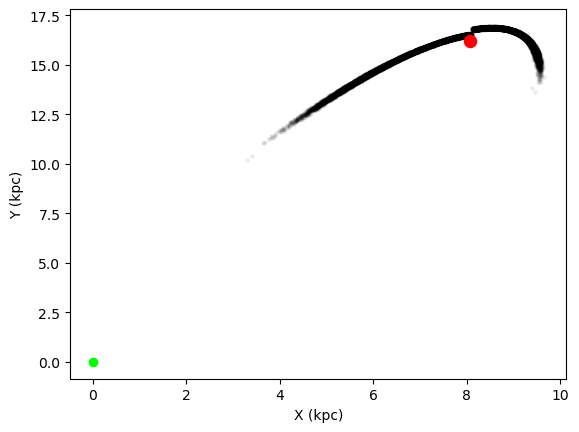

In [11]:
#3D representation
#Cluster, local background potential
#Pal5
c = ac.ICRS(ra=230 * u.deg, dec=-0.123 * u.deg,
               distance=22.9 * u.kpc,
               pm_ra_cosdec=-2.296 * u.mas/u.yr,
               pm_dec=-2.257 * u.mas/u.yr,
               radial_velocity=-58.7 * u.km/u.s)
               
c_gc = c.transform_to(galcen_frame)
fig2 = plt.figure()
ax2 = fig2.add_subplot()

ax2.scatter(x_s, z_s, alpha=0.05, s=5, c='k')#sts
ax2.scatter(c_gc.cartesian.x,c_gc.cartesian.z,s=75, c='r')#progenitor
ax2.scatter(0,0, c='lime')#galatic center

ax2.set_xlabel('X (kpc)')
ax2.set_ylabel('Y (kpc)')
# ax2.set_zlabel('Z')

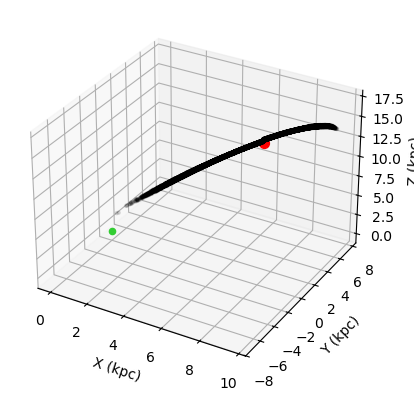

In [12]:
#3D representation
#Cluster, local background potential
# %matplotlib widget
# print(c.pm_ra_cosdec.to_value(u.mas/u.yr))
fig3 = plt.figure()
ax3 = fig3.add_subplot(projection='3d')

ax3.scatter(x_s, y_s ,z_s, alpha=0.1,s=5, c='k')#sts
ax3.scatter(c_gc.cartesian.x,c_gc.cartesian.y, c_gc.cartesian.z,s=50, c='r')#progenitor
ax3.scatter(0,0,0, c='limegreen')#galatic center

ax3.set_xlabel('X (kpc)')
ax3.set_ylabel('Y (kpc)')
ax3.set_zlabel('Z (kpc)')
plt.show()

In [13]:
# import numpy as np
# import matplotlib.pyplot as plt

# star_colors = ['#9bb0ff', '#aabfff', '#cad8ff', '#f8f7ff', '#fff4e8', '#ffd2a1', '#ffcc6f']
# n = len(x_s)
# colors = np.random.choice(star_colors, size=n)

# fig3 = plt.figure(figsize=(10, 10))
# ax3 = fig3.add_subplot(projection='3d')

# fig3.patch.set_facecolor('black')
# ax3.set_facecolor('black')

# # background
# n_bg = 10000  
# bg_x = np.random.uniform(-15, 15, n_bg)
# bg_y = np.random.uniform(-15, 15, n_bg)
# bg_z = np.random.uniform(-5, 25, n_bg)
# bg_colors = np.random.choice(star_colors, size=n_bg)
# bg_mag = np.random.uniform(0.3, 0.7, n_bg) 
# bg_sizes = np.random.uniform(0.5, 3.0, n_bg)  # tailles aléatoires
# ax3.scatter(bg_x, bg_y, bg_z, alpha=bg_mag, s=bg_sizes, c=bg_colors)

# # STS
# ax3.scatter(-x_s, y_s, z_s, alpha=0.85, s=2, c=colors)

# # Progenitor
# ax3.scatter(c_gc.cartesian.x, c_gc.cartesian.y, c_gc.cartesian.z+0.67*u.kpc, alpha=0.89,
#             s=30, c='#ffd7f0', edgecolors='white', linewidths=0)

# # galactic center
# # ax3.scatter(0, 0, 0, s=10, c='#ffd700', edgecolors='white')

# # camera view
# ax3.view_init(elev=25, azim=120)

# # delete axis
# ax3.set_axis_off()

# # Export
# # plt.savefig("stellar_trail_cover.png", dpi=300, bbox_inches='tight')

# plt.show()


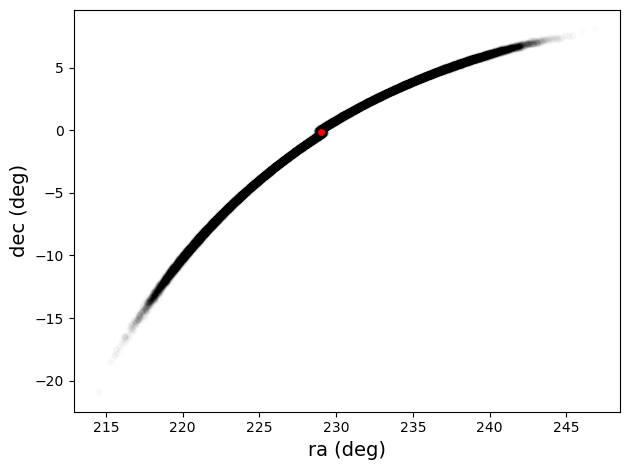

In [14]:
### plot the track in the radec frame to see how it would appears from an observer on earth
ra_prog, dec_prog = progenitor.loc[:,['ra']].values.tolist()[0], progenitor.loc[:,['dec']].values.tolist()[0]
# ra_prog, dec_prog = radec_prog
plt.figure()
# plt.scatter(ra_ps, dec_ps, s=0.5, c='purple')
plt.scatter(ra_s, dec_s, s=15, c='k', alpha=0.01)
plt.scatter(ra_prog, dec_prog, s=15, c='r')#progenitor

plt.xlabel("ra (deg)", fontsize=14)
plt.ylabel("dec (deg)", fontsize=14)
# plt.title("Stellar Stream (ICRS)")
plt.tight_layout()
plt.show()

In [15]:
### finally convert into Phi1,Phi2 frame
##this is a little bit tricky, since we cant the coordinate Phi1=0 follow the track, here we have 2 options:
# - Phi1=0 exactly follow the progenitor orbit. It means that we need to define a curviline abciss defined by the progenitor orbit
# - Phi1=0 is defined by the line which have the best fit with stellar streams stars, passing by the progenitor pos
#we choose for the moment option 2  

pole1 = ac.SkyCoord(ra=ra_prog*u.deg, dec=dec_prog*u.deg)
pole2 = ac.SkyCoord(ra=237.5*u.deg, dec=5*u.deg)

s_stars_phi12 = sutils.icrs_to_phi12(s_stars_icrs, pole1, pole2, velocities=True) 
phi1_s, phi2_s, dist_s, pm_phi1_s, pm_phi2_s, pmr_s = (s_stars_phi12.phi1, s_stars_phi12.phi2, s_stars_phi12.distance,
                                            s_stars_phi12.pm_phi1_cosphi2, s_stars_phi12.pm_phi2, s_stars_phi12.radial_velocity)

/tmp/ipykernel_7252/2165442653.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()



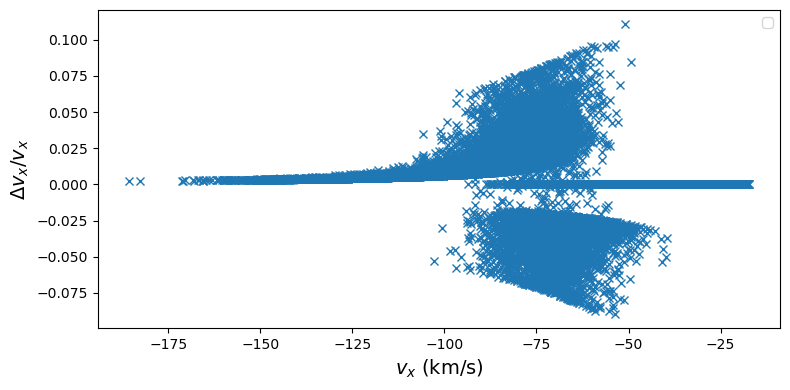

In [16]:
## Plot difference between perturbed and non perturbed vs non-perturbed

plt.figure(figsize=(8, 4))
plt.plot(s_lead_stars[5], (ps_stars[5]- s_lead_stars[5])/s_lead_stars[5], 'x')
plt.xlabel(r'$v_x$ (km/s)', fontsize=14)
plt.ylabel(r'$\Delta v_x/v_x$', fontsize=14)
# plt.title(r'Position difference in angle of stars along stream track')
# plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

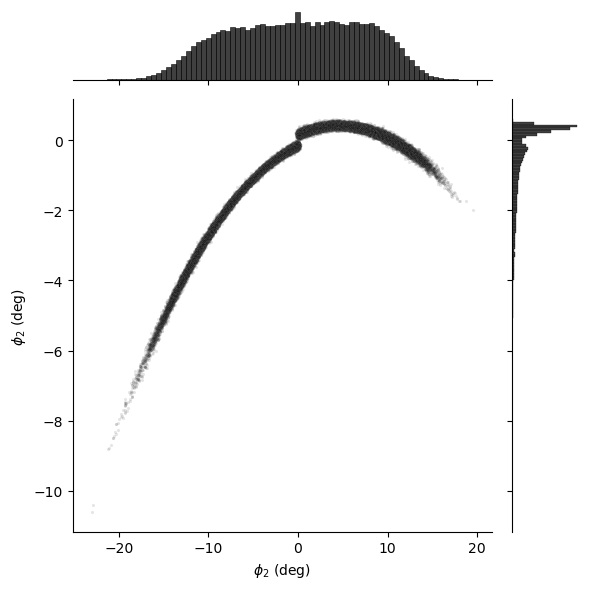

In [17]:
### plot the track in the radec frame to see how it would appears in the stream frame
# plt.figure()
# plt.scatter(phi12_ps_trail.phi1, phi12_ps_trail.phi2, s=0.5)
# plt.scatter(phi12_s_trail.phi1, phi12_s_trail.phi2, s=0.5)
# plt.scatter(ra_prog, dec_prog, s=10)
# plt.xlabel("ra [deg]")
# plt.ylabel("dec [deg]")
# plt.title("Perturbed Stellar Stream")
# plt.show()

sns.jointplot(x=phi1_s, y=phi2_s, alpha=0.1,s=5, color='k')
# ax1.scatter(phi12_ps_trail.phi1, phi12_ps_trail.phi2, s=0.5)
plt.xlabel(r"$\phi_2$ (deg)")
plt.ylabel(r"$\phi_2$ (deg)")

plt.tight_layout()



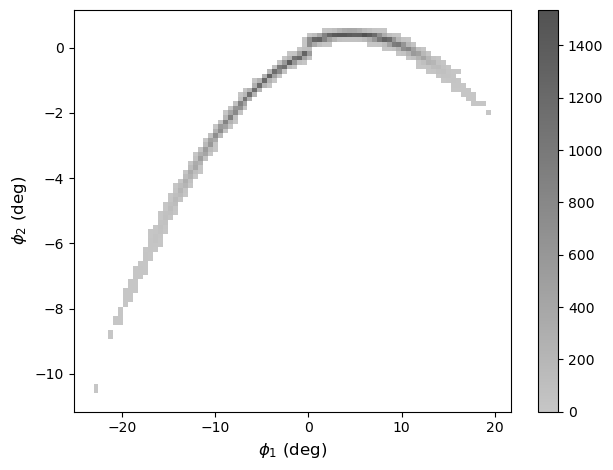

In [18]:
plt.figure()
hist2D = sns.histplot(x=phi1_s,y=phi2_s,bins=80, cbar=True, color='k')
plt.xlabel(r'$\phi_1$ (deg)',fontsize=12)
plt.ylabel(r'$\phi_2$ (deg)',fontsize=12)
plt.tight_layout()


**Step 4: magnitude sampling**

Optional. Gives gri magnitude to stars, depending on isochrone properties and distance modulus. Same class as from stream_sim magnitude sampler



In [19]:
import stream_galsim.stream_utils as sutils; reload(sutils) #custom .py file with utilities

<module 'stream_galsim.stream_utils' from '/home/hallouin/Documents/thall_2025/Streams/stream_sim/stream_galsim/stream_utils.py'>

In [20]:
config = {
    "name": "Bressan2012",
    "survey": "des",
    "age": 12.0,
    "z": 0.0006,
    "band_1": "g",
    "band_2": "r",
    "band_1_detection": True
}
isochrone_model = sutils.IsochroneModel(config)

mag_g_s, mag_r_s = isochrone_model.sample_magnitudes(s_stars_phi12)

In [21]:
# Save stars table with sampled magnitudes
sutils.save_star_data(s_stars_phi12, mag_g_s, mag_r_s, 'phi12', filepath=f"/home/hallouin/Documents/thall_2025/Streams/stream_sim/data/{cluster}_stars.csv")

Pandas DataFrame saved to: /home/hallouin/Documents/thall_2025/Streams/stream_sim/data/Pal5_stars.csv


,phi1,phi2,dist,mu1,mu2,rv,mag_g,mag_r
0,-3.250595,-0.682147,22.494358,-3.447591,-0.898807,-68.198091,27.993930,26.679037
1,0.054609,-0.280470,23.067034,-3.348495,-0.778950,-66.715849,28.472545,27.096643
2,-1.352661,-0.351198,22.911237,-3.380505,-0.812329,-66.260346,26.054204,25.044876
3,-13.073218,-3.901150,19.993291,-3.902753,-1.319647,-69.448774,25.432701,24.488623
4,-9.193111,-2.354750,21.026446,-3.710804,-1.144054,-71.757318,29.685601,28.129015
...,...,...,...,...,...,...,...,...
79995,10.163788,0.089082,24.140193,-3.163214,-0.493718,-55.471183,27.921118,26.638871
79996,12.051555,-0.338748,24.161604,-3.152368,-0.436958,-52.797438,28.353604,27.009202
79997,8.831833,0.209999,24.167865,-3.166573,-0.524505,-56.167339,24.724315,24.011013
79998,17.555715,-1.507846,23.704123,-3.185698,-0.335939,-44.830368,29.802674,28.263594


        phi1                 phi2         ...       mag_r       
-------------------- -------------------- ... ------------------
 -3.2505948892691663  -0.6821472904035016 ... 26.679036975241708
0.054609123688979674  -0.2804697409027373 ...  27.09664289947229
   -1.35266063681496 -0.35119750143305534 ... 25.044876020738325
 -13.073217826300322  -3.9011501222550096 ... 24.488622813697923
  -9.193111283882615  -2.3547503815276802 ... 28.129014566068083
  -1.933308557463988  -0.4236088169462584 ... 28.090658965176644
-0.33116488144571576  -0.2240650286595228 ... 25.940714753300647
 -3.7385131388696777  -0.8436616367343721 ...  22.53875431621693
  -9.267058636374372  -2.3592654362264818 ... 30.247421073945056
  -8.772092732399244   -2.198960635424041 ...   25.5613269921832
                 ...                  ... ...                ...
  11.162958612094252 -0.07972828852499098 ...  23.01022163215398
  5.6124148345232685  0.47754982367924675 ...  28.45038697420736
  1.7762826823129265  0.2

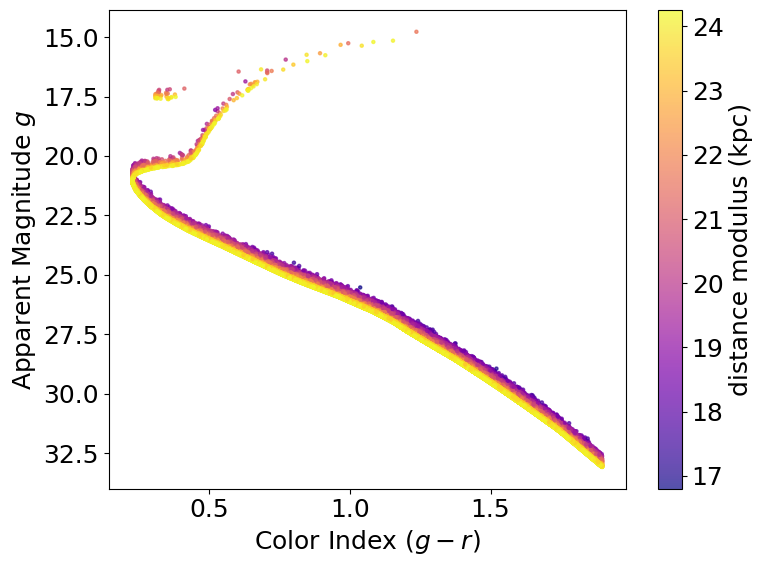

In [22]:
from astropy.table import Table
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
# Load the data
data_file = f"../data/{cluster}_stars.csv"  # Path to the saved CSV
Pal_5_stars = Table.read(data_file, format="csv")
print(Pal_5_stars)

# Compute the color index (g-r)
color_index = Pal_5_stars["mag_g"] - Pal_5_stars["mag_r"]

# H-R diagram (Absolute mag vs. Color index)
plt.figure(figsize=(8, 6))
plt.scatter(color_index, Pal_5_stars["mag_g"], s=5, c=Pal_5_stars["dist"], cmap="plasma", alpha=0.7)

# Flip the y-axis (brighter stars at the top)
plt.gca().invert_yaxis()

# Labels
plt.xlabel(r"Color Index $(g - r)$")
plt.ylabel(r"Apparent Magnitude $g$")
# plt.title(f"H-R Diagram (Pal5, age = {12.0}, z = 0.0006)")

# Colorbar
plt.colorbar(label="distance modulus (kpc)")

# Show the plot
plt.tight_layout()
plt.show()


# Stellar stream Density

Now that we got star distribution along the stream, we are interested in computing the density along the track. To do so we define a function that count the number of star in a given box. The density is defined as follow: Phi1 increase linearly in the range [Phimin,Phimax]. To each interval [Phi1-deltaPhi1,Phi1+deltaPhi1] is assigned a mid track width value Phi2. It is sum the number of stars in the column of witdh w corresponding to Phi1[i], where w is the sum of each bin size in the Phi2 direction, i.e. the width of the track. final"density_table" is in the same format as the erkal.csv file from stream_sim 

First part is for interpolated density parameter

In [85]:
mask= ((s_stars_phi12.phi1.value < -0.5) | (s_stars_phi12.phi1.value > 0.5)) & ((s_stars_phi12.phi1.value > -16) & (s_stars_phi12.phi1.value < 15))
# s_stars_phi12[(s_stars_phi12.phi1.value < -0.5) | (s_stars_phi12.phi1.value > -0.5)]

In [ ]:
###import homemade tools
import stream_galsim.stream_utils as sutils; reload(sutils)

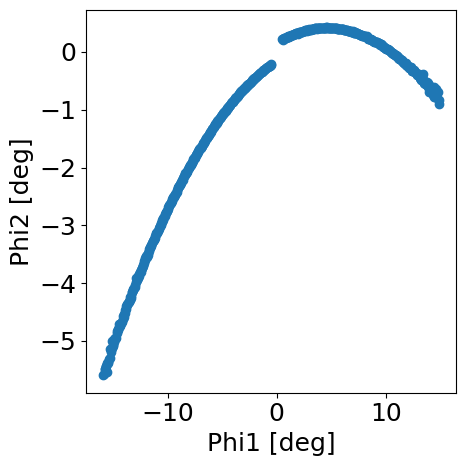

In [ ]:
#Fitting the main track, 
#Phi1 from min/max/deltaphi1
#gaussian at Phi1[i], along phi2
#Phi2 from gaussian mu
#nstars from gaussian max
#width from gaussian std

stream_track_density = sutils.StreamInterpolateTrackDensity(s_stars_phi12[mask])
density_table = stream_track_density.compute_density(delta_phi1=0.05, phi2_bins=15, plot=True, max_fev=1000000) #same format as erkal (Phi1,Phi2,nstars,width)

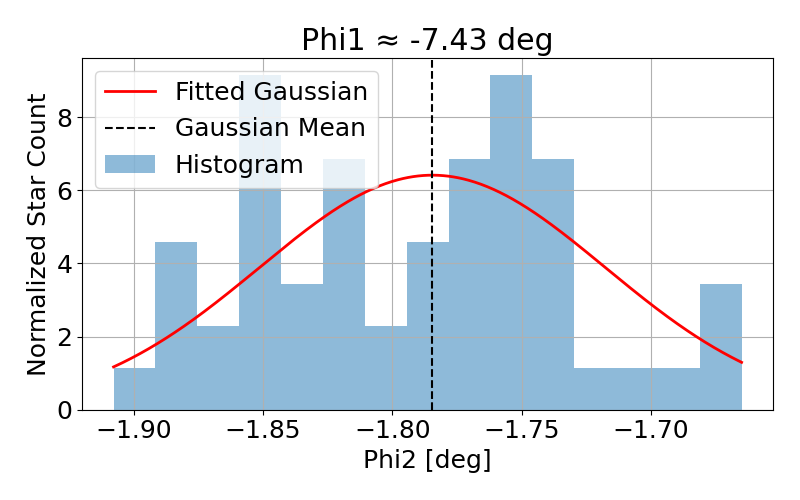

In [75]:
#Check if fit works
stream_track_density.plot_phi2_slice(phi1_target=-12.93, bins=15)

In [49]:
### Save data file to csv
# base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
density_table.write(f'{base_dir}/data/hall_2024_{cluster}_input.csv', format='csv', overwrite=True)

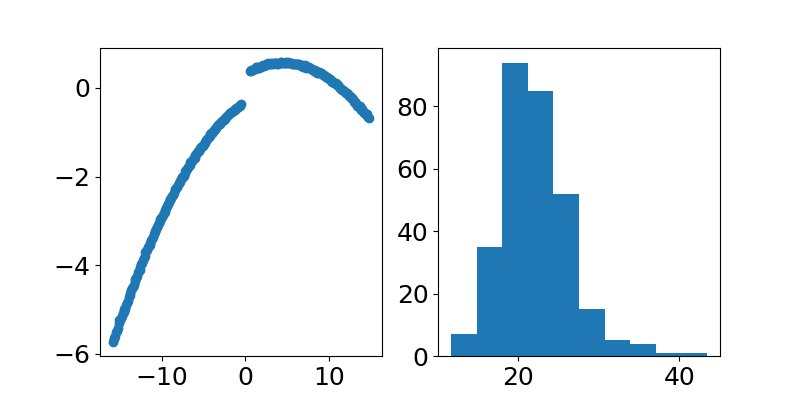

In [50]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.scatter(density_table['phi1'], density_table['phi2'])
plt.subplot(122)
plt.hist(density_table['nstars'])
plt.show()

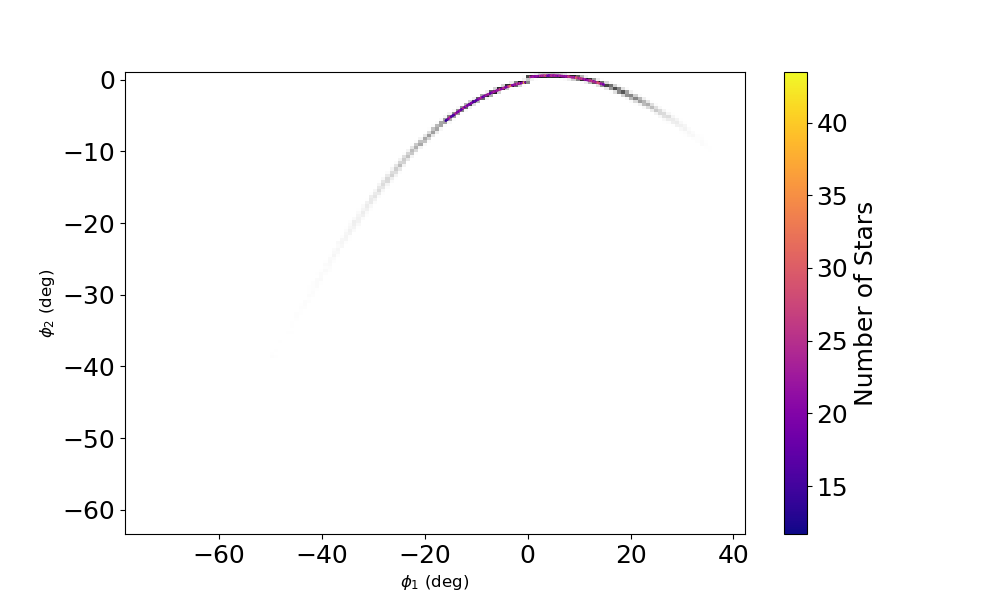

In [51]:
# Plot the density in the frame (scatter plot of phi1, phi2 values)
%matplotlib widget
plt.figure(figsize=(10, 6))
plt.hist2d(phi1_s.degree, phi2_s.degree, bins=[150, 150], cmap='binary')
plt.scatter(density_table['phi1'], density_table['phi2'], c=density_table['nstars'], cmap='plasma', s=0.5)
plt.colorbar(label='Number of Stars')
plt.xlabel(r'$\phi_1$ (deg)',fontsize=12)
plt.ylabel(r'$\phi_2$ (deg)',fontsize=12)
# plt.title('Star Density Along the Stream')
# plt.grid(True)
plt.show()

Second part is for true observed surfacic stellar density

In [ ]:
# Load the data
data_file = f"../data/{cluster}_stars.csv"  # Path to the saved CSV
Pal_5_stars = pd.read_csv(data_file)
Pal_5_stars

In [ ]:
analyzer = sutils.StreamDensityAnalyzer(Pal_5_stars, bin_width=0.1)
analyzer.compute_density()
coeffs, poly = analyzer.fit_polynomial(plot=True, degree=6)


In [ ]:
plt.figure(figsize=(8, 4))
# plt.plot(centers, (dens_norm_perturbed-dens_norm_unperturbed)/dens_norm_unperturbed, drawstyle='steps-mid')
plt.plot(centers, (poly_model_perturbed(centers)-poly_model_unperturbed(centers))/poly_model_unperturbed(centers), color='red')
plt.xlabel(r'$\phi_1$ (°)')
plt.ylabel(r'$\delta(\phi_1)$')
plt.title("Relative stellar density difference along stream track")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
